# Benchmarking classification time-complexity of SPORF on sklearn `bench_tree.py`

The purpose of the notebook is to benchmark time-complexity of S-RerF on one of the sklearn benchmarking scripts

## Environment
- Python 3.8
- [Sklearn-Adam's dev branch](https://github.com/neurodata/scikit-learn/tree/obliquetrees)

## Import packages

In [1]:
from sklearn.tree import ObliqueDecisionTreeClassifier
from sklearn.ensemble import ObliqueRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle
from datetime import datetime
import os

import numpy as np
import matplotlib.pyplot as plt
import gc
from datetime import datetime

# to store the results
scikit_classifier_results = []

train_switch = True #pkl save toggle
fig_switch = True #fig save toggle

mu_second = 0.0 + 10 ** 6  # number of microseconds in a second

In [2]:
today = str(datetime.now().date())
today = '2021-12-21'

## SPORF initialization

In [3]:
def init():
    clf_otree = ObliqueDecisionTreeClassifier()
    clf_oforest = ObliqueRandomForestClassifier()

    return clf_otree, clf_oforest

## Tree Benchmarking for classification adapted from sklearn `main` and modified for sporf benchmarking

In [4]:
def bench_scikit_tree_classifier(X, Y, c=None):
    """Benchmark with scikit-learn decision tree classifier"""

    if not c:
        clf = RandomForestClassifier()
    else:
        clf = init()[c]

    gc.collect()

    tstart = datetime.now()
    clf.fit(X, Y).predict(X)
    delta = datetime.now() - tstart

    scikit_classifier_results.append(delta.seconds + delta.microseconds / mu_second)

### Parameterization is in reference to sklearn issue [#20819](https://github.com/scikit-learn/scikit-learn/issues/20819)

In [5]:
def run_test(n_samples=0, n=20, dim=10, step=5000, c=None, filename=None, train=True, switch=train_switch):
    global scikit_classifier_results

    if not train:
        try:
            with open(filename, 'rb') as handle:
                scikit_classifier_results = pickle.load(handle)
                print(f'[{filename}] loaded')
        except Exception as e:
            print(e)

        return scikit_classifier_results
    
    scikit_classifier_results = []

    t_i = datetime.now()

    dim = dim
    n_classes = 10
    for i in range(n):
        n_samples += step
        X = np.random.randn(n_samples, dim)
        Y = np.random.randint(0, n_classes, (n_samples,))
        bench_scikit_tree_classifier(X, Y, c=c)

    print(f'Total Runtime over {n} experiments: {datetime.now()-t_i}')
    
    if filename and switch:
        with open(filename, 'wb') as handle:
            pickle.dump(scikit_classifier_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return scikit_classifier_results


### Generate Figure

In [6]:
def generate_fig(dim=10, fig_switch=True):
    fig, ax = plt.subplots(1,1, figsize=(20,5))

    xx = np.arange(step,n*step+step, step)
    ax.plot(xx, rf_result, marker='o', label='Random Forest')
    ax.plot(xx, otree_result, marker='o', label='Oblique Tree')
    ax.plot(xx, oforest_result, marker='o', label='Oblique Forest')

    ax.set_xlabel('Number of Samples', fontsize=18)
    ax.set_ylabel('Runtime for Training (secs)', fontsize=18)
    ax.legend(fontsize='20')
    ax.set_title(f'Runtime Performance with {dim} dimensions', fontsize=18)

    #save figure
    if fig_switch:
        fig.savefig(f'{today}_runtime_performance_source_base_dim={dim}.jpg', bbox_inches='tight')


## Run sklearn tree benchmark

#### benchmarking setting

In [7]:
n = 10 # number of experiments with sample size increment of `step`
step = 10000 #step size
dim = [10, 100, 1000] #dim of the simulation
saveDir = 'dat' #pickle save directory
np.random.RandomState(12345) #random state
train = True #training switch

if not os.path.isdir(saveDir):
    os.mkdir(saveDir)

#### benchmark for RF, oblique decision tree and oblique forest

##############################
Benchmarking with 10 dimension
##############################
[dat/2021-12-21_tree_benchmark_RF_dev_dim=10.pkl] loaded
[dat/2021-12-21_tree_benchmark_otree_dev_dim=10.pkl] loaded
[dat/2021-12-21_tree_benchmark_oforest_dev_dim=10.pkl] loaded
##############################
Benchmarking with 100 dimension
##############################
[dat/2021-12-21_tree_benchmark_RF_dev_dim=100.pkl] loaded
[dat/2021-12-21_tree_benchmark_otree_dev_dim=100.pkl] loaded
[dat/2021-12-21_tree_benchmark_oforest_dev_dim=100.pkl] loaded
##############################
Benchmarking with 1000 dimension
##############################
[dat/2021-12-21_tree_benchmark_RF_dev_dim=1000.pkl] loaded
[dat/2021-12-21_tree_benchmark_otree_dev_dim=1000.pkl] loaded
[dat/2021-12-21_tree_benchmark_oforest_dev_dim=1000.pkl] loaded


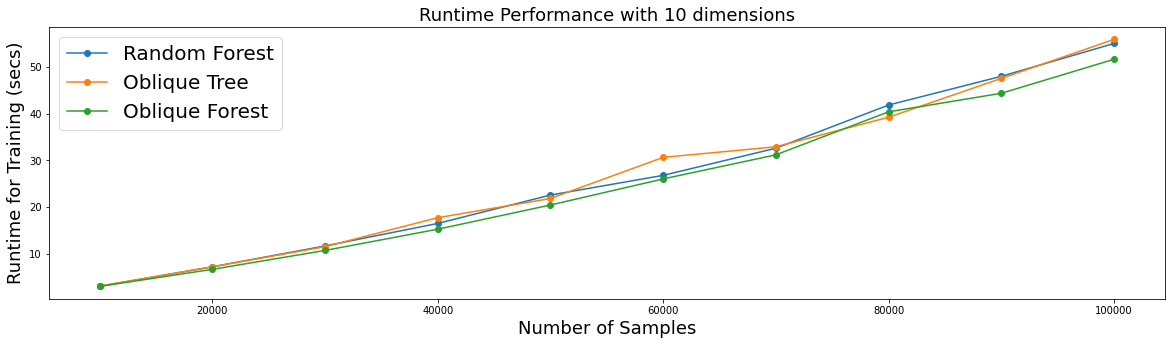

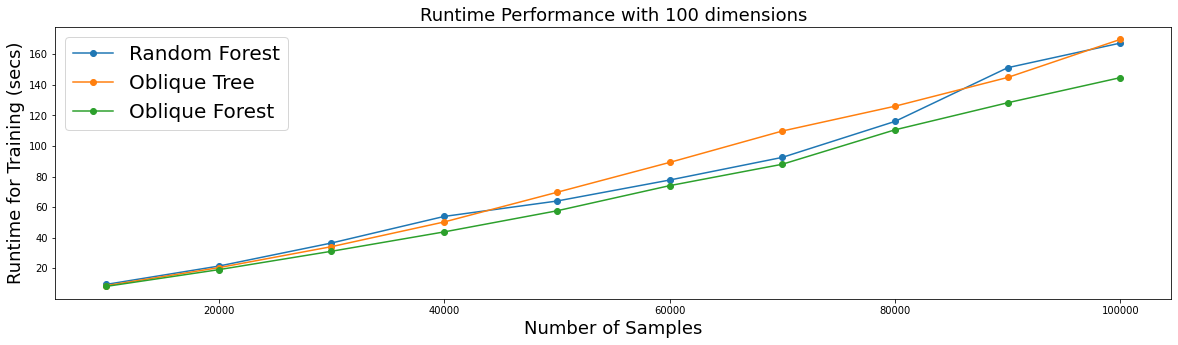

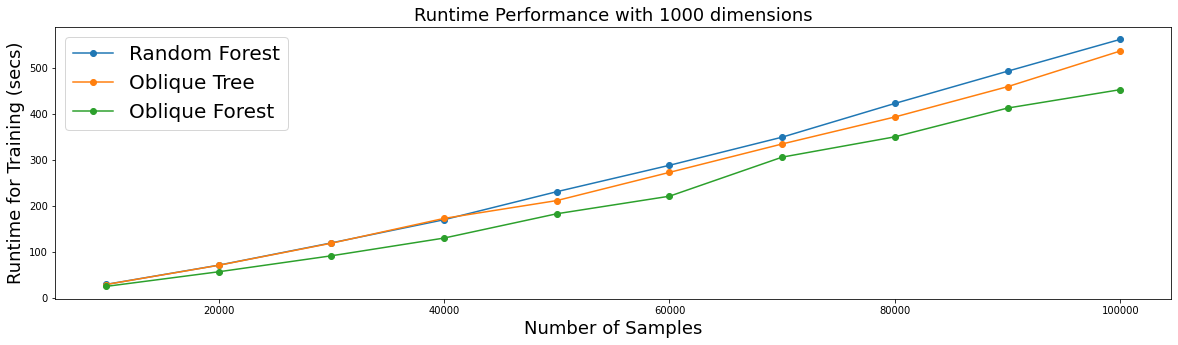

In [8]:
for i in dim:
    print(f"{'#' * 30}\nBenchmarking with {i} dimension\n{'#' * 30}")
    clf_otree, clf_oforest = init()
    rf_result = run_test(n=n, dim=i, filename=f'{saveDir}/{today}_tree_benchmark_RF_dev_dim={i}.pkl', train=False)
    otree_result = run_test(n=n, dim=i, c=0, filename=f'{saveDir}/{today}_tree_benchmark_otree_dev_dim={i}.pkl', train=False)
    oforest_result = run_test(n=n, dim=i, c=1, filename=f'{saveDir}/{today}_tree_benchmark_oforest_dev_dim={i}.pkl', train=False)

    generate_fig(dim=i, fig_switch=fig_switch)